In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Bayesian Neural Networks

So far, our discussion of neural networks has focused on the use of maximum likelihood to determine the network parameters (weights and biases). Regularized maximum likelihood can be interpreted as a MAP (maximum posterior) approach in which the regularizer can be viewed as the logarithm of a prior parameter distribution. However, in a Bayesian treatment, we need to marginalize over the distribution of parameters in order to make predictions. 

In Section 3.3, we developed a Bayesian solution for a simple linear regression model under the assumption of Gaussian noise. We saw that the posterior distribution, which is Gaussian, could be evaluated exactly, and the predictive distribution could also be found in closed form. 

In the case of a multilayered network, the highly nonlinear dependence of the network function on the parameter values means that an exact Bayesian treatment can no longer be found. In fact, the log of the posterior distribution will be non-convex, corresponding to the multiple local minima in the error function. 

The technique of variational inference, to be discussed in Chapter 10, has been applied to Bayesian neural networks using a factorized Gaussian approximation to the posterior distribution (Hinton and van Camp, 1993) and also using a full-covariance Gaussian (Barber and Bishop, 1998a; Barber and Bishop, 1998b). The most complete treatment, however, has been based on the Laplace approximation (MacKay, 1992c; MacKay, 1992b) and forms the basis for the discussion given here. We will approximate the posterior distribution by a Gaussian, centered at a mode of the true posterior. Furthermore, we shall assume that the covariance of this Gaussian is small so that the network function is approximately linear with respect to the parameters over the region of parameter space for which the posterior probability is significantly nonzero. With these two approximations, we will obtain models that are analogous to the linear regression and classification models discussed in earlier chapters and so we can exploit the results obtained there. We can then make use of the evidence framework to provide point estimates for the hyperparameters and to compare alternative models (for example, networks having different numbers of hidden units). To start with, we shall discuss the regression case and then later consider the modifications needed for solving classification tasks.

## Posterior Parameter Distribution

Consider the problem of predicting a single continuous target variable $ t $ from a vector $ x $ of inputs (the extension to multiple targets is straightforward). We shall suppose that the conditional distribution $ p(t|x) $ is Gaussian, with an $ x $-dependent mean given by the output of a neural network model $ y(x, w) $, and with precision (inverse variance) $ \beta $:

$$
p(t|x, w, \beta) = \mathcal{N}(t | y(x, w), \beta^{-1})
$$

Similarly, we shall choose a prior distribution over the weights $ w $ that is Gaussian of the form:

$$
p(w|\alpha) = \mathcal{N}(w | 0, \alpha^{-1} I)
$$

For an i.i.d. data set of $ N $ observations $ x_1, \dots, x_N $, with a corresponding set of target values $ D = \{t_1, \dots, t_N\} $, the likelihood function is given by:

$$
p(D | w, \beta) = \prod_{n=1}^{N} \mathcal{N}(t_n | y(x_n, w), \beta^{-1})
$$

The resulting posterior distribution is then:

$$
p(w | D, \alpha, \beta) \propto p(w|\alpha) p(D | w, \beta)
$$

Which, as a consequence of the nonlinear dependence of $ y(x, w) $ on $ w $, will be non-Gaussian. We can find a Gaussian approximation to the posterior distribution by using the Laplace approximation. To do this, we must first find a (local) maximum of the posterior, and this must be done using iterative numerical optimization. 

As usual, it is convenient to maximize the logarithm of the posterior, which can be written as:

$$
\ln p(w|D) = - \frac{\alpha}{2} w^T w - \sum_{n=1}^{N} \frac{1}{2} \beta \left( y(x_n, w) - t_n \right)^2 + \text{constant}
$$

This corresponds to a regularized sum-of-squares error function. Assuming for the moment that $ \alpha $ and $ \beta $ are fixed, we can find a maximum of the posterior, which we denote $ w_{\text{MAP}} $, by standard nonlinear optimization algorithms such as conjugate gradients, using error backpropagation to evaluate the required derivatives.

Having found a mode $ w_{\text{MAP}} $, we can then build a local Gaussian approximation by evaluating the matrix of second derivatives of the negative log posterior distribution. From the equation above, this is given by:

$$
A = -\nabla\nabla \ln p(w|D, \alpha, \beta) = \alpha I + \beta H
$$

Where $ H $ is the Hessian matrix comprising the second derivatives of the sum-of-squares error function with respect to the components of $ w $. The corresponding Gaussian approximation to the posterior is then:

$$
q(w|D) = \mathcal{N}(w | w_{\text{MAP}}, A^{-1})
$$

Similarly, the predictive distribution is obtained by marginalizing with respect to this posterior distribution:

$$
p(t | x, D) = \int p(t | x, w) q(w | D) dw
$$

However, even with the Gaussian approximation to the posterior, this integration is still analytically intractable due to the nonlinearity of the network function $ y(x, w) $ as a function of $ w $. 

To make progress, we now assume that the posterior distribution has small variance compared with the characteristic scales of $ w $ over which $ y(x, w) $ is varying. This allows us to make a Taylor series expansion of the network function around $ w_{\text{MAP}} $ and retain only the linear terms:

$$
y(x, w) \approx y(x, w_{\text{MAP}}) + g^T (w - w_{\text{MAP}})
$$

Where we have defined $ g = \nabla_w y(x, w) \big|_{w=w_{\text{MAP}}} $.

With this approximation, we now have a linear-Gaussian model with a Gaussian distribution for $ p(w) $ and a Gaussian for $ p(t|w) $ whose mean is a linear function of $ w $:

$$
p(t|x, w, \beta) \approx \mathcal{N}(t | y(x, w_{\text{MAP}}) + g^T (w - w_{\text{MAP}}), \beta^{-1})
$$

We can therefore make use of the general result for the marginal:

$$
p(t | x, D, \alpha, \beta) = \mathcal{N}(t | y(x, w_{\text{MAP}}), \sigma^2(x))
$$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define the neural network model
class BayesianNeuralNetwork:
    def __init__(self, input_dim, hidden_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        # Initialize weights and biases for a single hidden layer
        self.W1 = np.random.randn(input_dim, hidden_dim)
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, 1)
        self.b2 = np.zeros((1, 1))
    
    def forward(self, X):
        """Forward pass of the neural network."""
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = np.tanh(self.Z1)  # Activation function
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        return self.Z2

    def compute_loss(self, X, y, beta=1.0, alpha=1.0):
        """Compute the negative log posterior (including prior and likelihood)."""
        # Predict
        y_pred = self.forward(X)
        
        # Likelihood term (sum of squared errors, with precision beta)
        likelihood = np.sum((y - y_pred) ** 2)
        
        # Prior term (L2 regularization on weights)
        prior = alpha * (np.sum(self.W1 ** 2) + np.sum(self.W2 ** 2))
        
        # Combine the terms: negative log posterior
        return (0.5 * beta * likelihood) + (0.5 * prior)
    
    def gradient(self, X, y, beta=1.0, alpha=1.0):
        """Compute gradients of the negative log posterior."""
        y_pred = self.forward(X)
        
        # Gradients for output layer (W2, b2)
        dZ2 = y_pred - y
        dW2 = np.dot(self.A1.T, dZ2) + alpha * self.W2  # Add L2 regularization term
        db2 = np.sum(dZ2, axis=0, keepdims=True)
        
        # Gradients for hidden layer (W1, b1)
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * (1 - self.A1 ** 2)  # Derivative of tanh activation
        dW1 = np.dot(X.T, dZ1) + alpha * self.W1  # Add L2 regularization term
        db1 = np.sum(dZ1, axis=0, keepdims=True)
        
        # Return gradients
        return dW1, db1, dW2, db2
    
    def train(self, X_train, y_train, learning_rate=0.01, epochs=1000, beta=1.0, alpha=1.0):
        """Train the Bayesian Neural Network."""
        for epoch in range(epochs):
            # Compute the gradients
            dW1, db1, dW2, db2 = self.gradient(X_train, y_train, beta, alpha)
            
            # Update weights using gradient descent
            self.W1 -= learning_rate * dW1
            self.b1 -= learning_rate * db1
            self.W2 -= learning_rate * dW2
            self.b2 -= learning_rate * db2
            
            # Print the loss every 100 epochs
            if epoch % 100 == 0:
                loss = self.compute_loss(X_train, y_train, beta, alpha)
                print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X):
        """Make predictions using the trained model."""
        return self.forward(X)

# Generate synthetic regression data
X, y = make_regression(n_samples=100, n_features=1, noise=0.1, random_state=42)
X = X.reshape(-1, 1)  # Reshape for the model

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate and train the model
input_dim = X_train.shape[1]
hidden_dim = 10  # Hidden layer size
bnn = BayesianNeuralNetwork(input_dim, hidden_dim)

# Train the model
bnn.train(X_train, y_train, learning_rate=0.01, epochs=2000)

# Make predictions
y_pred = bnn.predict(X_test)

# Plot the results
plt.scatter(X_test, y_test, color='blue', label='True Data')
plt.plot(X_test, y_pred, color='red', label='Predictions')
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("Bayesian Neural Network Predictions")
plt.show()


### Predictive Distribution with Input-Dependent Variance

The input-dependent variance is given by:

$$
\sigma^2(x) = \beta^{-1} + \mathbf{g}^\top \mathbf{A}^{-1} \mathbf{g}. \tag{5.173}
$$

We observe that the predictive distribution $ p(t | \mathbf{x}, \mathcal{D}) $ is a Gaussian, where the mean is given by the network function $ y(\mathbf{x}, \mathbf{w}_{\text{MAP}}) $, with the parameters set to their Maximum A Posteriori (MAP) values. 

The variance of the predictive distribution has two components:

1. **Intrinsic Noise**: 
   $$ \beta^{-1} $$
   This term arises from the intrinsic noise on the target variable.

2. **Uncertainty in the Model Parameters**:
   $$ \mathbf{g}^\top \mathbf{A}^{-1} \mathbf{g} $$
   This is an $\mathbf{x}$-dependent term that expresses the uncertainty in the interpolant due to the uncertainty in the model parameters $ \mathbf{w} $.

This predictive distribution can be compared to the corresponding predictive distribution for the linear regression model, given by:

- Mean:
  $$
  \mu(x) = \mathbf{x}^\top \mathbf{w}_{\text{MAP}}
  $$

- Variance:
  $$
  \sigma^2(x) = \beta^{-1} + \mathbf{x}^\top \mathbf{S} \mathbf{x}.
  $$


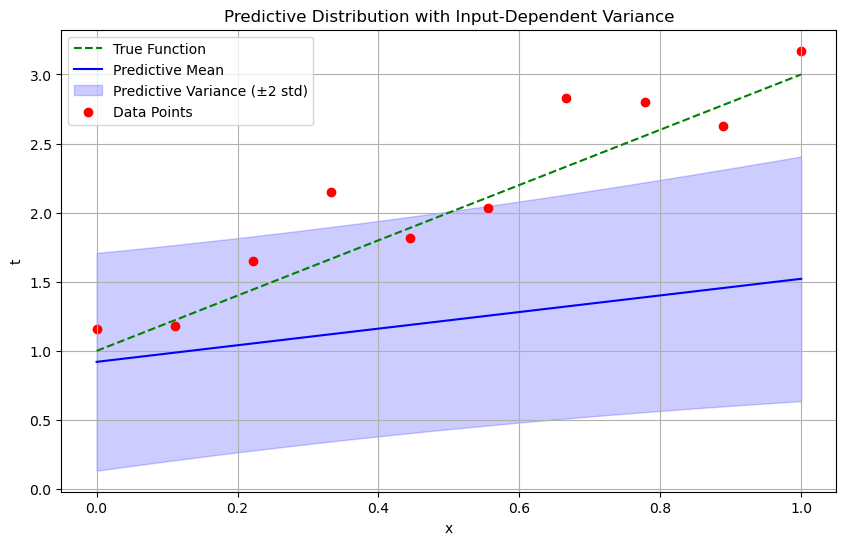

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate data
np.random.seed(42)
n_points = 10  # Number of data points
x_data = np.linspace(0, 1, n_points)
true_function = lambda x: 2 * x + 1  # Linear function y = 2x + 1
noise_variance = 0.1
t_data = true_function(x_data) + np.random.normal(0, np.sqrt(noise_variance), n_points)

# Step 2: Define the design matrix and compute MAP solution
X = np.vstack((np.ones(n_points), x_data)).T  # Design matrix with bias term
beta_inv = noise_variance  # Noise variance
beta = 1 / beta_inv

# Compute precision matrix (A = X^T X + beta * I)
A = np.dot(X.T, X) + beta * np.eye(X.shape[1])

# Compute MAP weights (w_MAP = (X^T X + beta * I)^-1 X^T t)
w_MAP = np.linalg.solve(A, np.dot(X.T, t_data))

# Step 3: Predictive mean and variance
x_test = np.linspace(0, 1, 100)
X_test = np.vstack((np.ones(len(x_test)), x_test)).T

# Predictive mean
predictive_mean = np.dot(X_test, w_MAP)

# Predictive variance (sigma^2(x) = beta^-1 + x^T A^-1 x)
A_inv = np.linalg.inv(A)
predictive_variance = np.array([beta_inv + np.dot(x, np.dot(A_inv, x)) for x in X_test])

# Step 4: Plot the results
plt.figure(figsize=(10, 6))

# Plot the true function
plt.plot(x_test, true_function(x_test), 'g--', label="True Function")

# Plot the predictive mean
plt.plot(x_test, predictive_mean, 'b-', label="Predictive Mean")

# Plot the predictive variance as a shaded region
plt.fill_between(
    x_test,
    predictive_mean - 2 * np.sqrt(predictive_variance),
    predictive_mean + 2 * np.sqrt(predictive_variance),
    color="blue",
    alpha=0.2,
    label="Predictive Variance (±2 std)",
)

# Plot the data points
plt.scatter(x_data, t_data, color="red", label="Data Points")

# Labels and legend
plt.xlabel("x")
plt.ylabel("t")
plt.title("Predictive Distribution with Input-Dependent Variance")
plt.legend()
plt.grid()
plt.show()


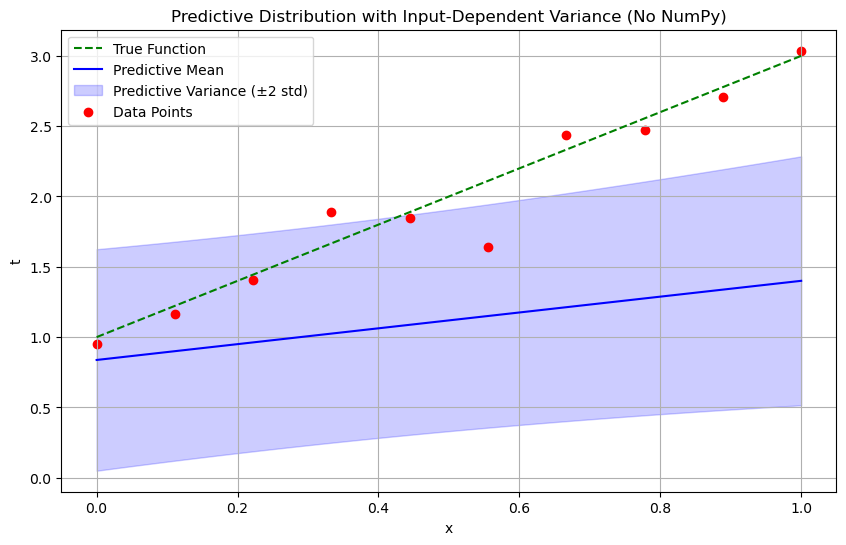

In [2]:
import random
import matplotlib.pyplot as plt

# Step 1: Generate data
random.seed(42)
n_points = 10  # Number of data points
x_data = [i / (n_points - 1) for i in range(n_points)]  # Equally spaced x values
true_function = lambda x: 2 * x + 1  # Linear function y = 2x + 1
noise_variance = 0.1
t_data = [true_function(x) + random.gauss(0, noise_variance**0.5) for x in x_data]

# Helper functions
def transpose(matrix):
    return list(map(list, zip(*matrix)))

def matrix_mult(A, B):
    """Matrix multiplication."""
    return [
        [sum(A[i][k] * B[k][j] for k in range(len(B))) for j in range(len(B[0]))]
        for i in range(len(A))
    ]

def inverse_2x2(matrix):
    """Inverse of a 2x2 matrix."""
    det = matrix[0][0] * matrix[1][1] - matrix[0][1] * matrix[1][0]
    return [
        [matrix[1][1] / det, -matrix[0][1] / det],
        [-matrix[1][0] / det, matrix[0][0] / det],
    ]

def dot(vec1, vec2):
    """Dot product of two vectors."""
    return sum(v1 * v2 for v1, v2 in zip(vec1, vec2))

# Step 2: Define the design matrix and compute MAP solution
X = [[1, x] for x in x_data]  # Design matrix with bias term
beta_inv = noise_variance  # Noise variance
beta = 1 / beta_inv

# Compute A = X^T X + beta * I
X_T = transpose(X)
XT_X = matrix_mult(X_T, X)
identity = [[1 if i == j else 0 for j in range(2)] for i in range(2)]
A = [[XT_X[i][j] + beta * identity[i][j] for j in range(2)] for i in range(2)]

# Compute w_MAP = A^-1 X^T t
A_inv = inverse_2x2(A)
XT_t = [dot(row, t_data) for row in X_T]
w_MAP = [dot(A_inv_row, XT_t) for A_inv_row in A_inv]

# Step 3: Predictive mean and variance
x_test = [i / 99 for i in range(100)]
X_test = [[1, x] for x in x_test]

# Predictive mean
predictive_mean = [dot(w_MAP, row) for row in X_test]

# Predictive variance
predictive_variance = []
for x in X_test:
    A_inv_x = [dot(A_inv_row, x) for A_inv_row in A_inv]
    var = beta_inv + dot(x, A_inv_x)
    predictive_variance.append(var)

# Step 4: Plot the results
plt.figure(figsize=(10, 6))

# Plot the true function
plt.plot(x_test, [true_function(x) for x in x_test], 'g--', label="True Function")

# Plot the predictive mean
plt.plot(x_test, predictive_mean, 'b-', label="Predictive Mean")

# Plot the predictive variance as a shaded region
plt.fill_between(
    x_test,
    [m - 2 * v**0.5 for m, v in zip(predictive_mean, predictive_variance)],
    [m + 2 * v**0.5 for m, v in zip(predictive_mean, predictive_variance)],
    color="blue",
    alpha=0.2,
    label="Predictive Variance (±2 std)",
)

# Plot the data points
plt.scatter(x_data, t_data, color="red", label="Data Points")

# Labels and legend
plt.xlabel("x")
plt.ylabel("t")
plt.title("Predictive Distribution with Input-Dependent Variance (No NumPy)")
plt.legend()
plt.grid()
plt.show()


## Hyperparameter Optimization and Bayesian Neural Networks

### Hyperparameter Optimization

### Marginal Likelihood for Hyperparameters

The marginal likelihood, or evidence, for the hyperparameters is obtained by integrating over the network weights:

$$
p(\mathcal{D} | \alpha, \beta) = \int p(\mathcal{D} | \mathbf{w}, \beta) p(\mathbf{w} | \alpha) \, d\mathbf{w}. \tag{5.174}
$$

Using the Laplace approximation (Equation 4.135), the logarithm of the evidence is given by:

$$
\ln p(\mathcal{D} | \alpha, \beta) \approx -E(\mathbf{w}_{\text{MAP}}) - \frac{1}{2} \ln |\mathbf{A}| + \frac{W}{2} \ln \alpha + \frac{N}{2} \ln \beta - \frac{N}{2} \ln(2\pi), \tag{5.175}
$$

where:
- $ W $ is the total number of parameters in $\mathbf{w}$,
- $ N $ is the number of data points,
- $ E(\mathbf{w}_{\text{MAP}}) $ is the regularized error function:
  $$
  E(\mathbf{w}_{\text{MAP}}) = \frac{\beta}{2} \sum_{n=1}^N \left( y(\mathbf{x}_n, \mathbf{w}_{\text{MAP}}) - t_n \right)^2 + \frac{\alpha}{2} \mathbf{w}_{\text{MAP}}^\top \mathbf{w}_{\text{MAP}}. \tag{5.176}
  $$

This takes the same form as the corresponding result for linear regression (Equation 3.86).

### Re-estimation of Hyperparameters

The hyperparameters $\alpha$ and $\beta$ are updated by maximizing $\ln p(\mathcal{D} | \alpha, \beta)$.

#### Re-estimation of $\alpha$:
Using the eigenvalue equation:

$$
\beta \mathbf{H} \mathbf{u}_i = \lambda_i \mathbf{u}_i, \tag{5.177}
$$

where $\mathbf{H}$ is the Hessian of the error function, the update equation for $\alpha$ is:

$$
\alpha = \frac{\gamma}{\mathbf{w}_{\text{MAP}}^\top \mathbf{w}_{\text{MAP}}}, \tag{5.178}
$$

with $\gamma$, the effective number of parameters, defined as:

$$
\gamma = \sum_{i=1}^W \frac{\lambda_i}{\alpha + \lambda_i}. \tag{5.179}
$$

#### Re-estimation of $\beta$:
The update equation for $\beta$ is:

$$
\frac{1}{\beta} = \frac{1}{N - \gamma} \sum_{n=1}^N \left( y(\mathbf{x}_n, \mathbf{w}_{\text{MAP}}) - t_n \right)^2. \tag{5.180}
$$

The re-estimation alternates between updating $\alpha$, $\beta$, and the posterior distribution.

---

## Bayesian Neural Networks for Classification

### Log Likelihood for Classification

For a network with a single logistic sigmoid output for two-class classification, the log likelihood is:

$$
\ln p(\mathcal{D} | \mathbf{w}) = \sum_{n=1}^N \left[ t_n \ln y_n + (1 - t_n) \ln (1 - y_n) \right], \tag{5.181}
$$

where $t_n \in \{0, 1\}$ are the target values, and $y_n \equiv y(\mathbf{x}_n, \mathbf{w})$.

### Regularized Error Function

The regularized error function, used for determining $\mathbf{w}_{\text{MAP}}$, is:

$$
E(\mathbf{w}) = -\ln p(\mathcal{D} | \mathbf{w}) + \frac{\alpha}{2} \mathbf{w}^\top \mathbf{w}. \tag{5.182}
$$

### Log Evidence for Classification

The marginal likelihood for classification is:

$$
\ln p(\mathcal{D} | \alpha) \approx -E(\mathbf{w}_{\text{MAP}}) - \frac{1}{2} \ln |\mathbf{A}| + \frac{W}{2} \ln \alpha + \text{const}, \tag{5.183}
$$

with:

$$
E(\mathbf{w}_{\text{MAP}}) = -\sum_{n=1}^N \left[ t_n \ln y_n + (1 - t_n) \ln (1 - y_n) \right] + \frac{\alpha}{2} \mathbf{w}_{\text{MAP}}^\top \mathbf{w}_{\text{MAP}}. \tag{5.184}
$$

---

## Notes on Computational Challenges

- Evaluating the determinant $|\mathbf{A}|$ of the Hessian matrix can be sensitive to small eigenvalues.
- The Laplace approximation considers local quadratic expansion around a mode of the posterior distribution, accounting for symmetries in hidden units for neural networks.

---

This content explores hyperparameter optimization and Bayesian neural networks for classification, with references to the evidence framework, Laplace approximation, and re-estimation procedures.


Iteration 1: alpha = 0.6351, beta = 3.4859
Iteration 2: alpha = 0.5639, beta = 3.8957
Iteration 3: alpha = 0.5539, beta = 3.9543
Iteration 4: alpha = 0.5524, beta = 3.9628
Iteration 5: alpha = 0.5521, beta = 3.9641
Iteration 6: alpha = 0.5521, beta = 3.9643
Iteration 7: alpha = 0.5521, beta = 3.9643
Iteration 8: alpha = 0.5521, beta = 3.9643
Iteration 9: alpha = 0.5521, beta = 3.9643
Iteration 10: alpha = 0.5521, beta = 3.9643

Optimized hyperparameters:
alpha = 0.5521
beta = 3.9643

MAP weights (w_MAP):
[1.1499631673850694, 1.485349901272694]


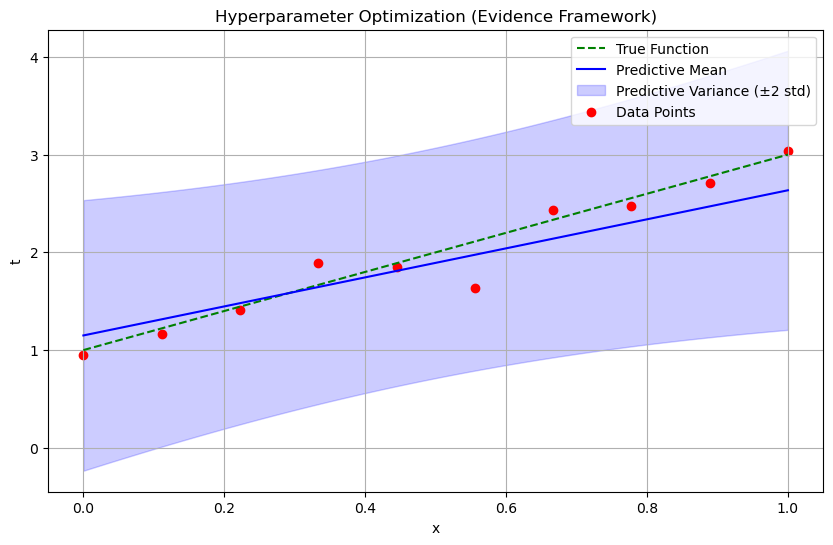

In [3]:
import random
import math

# Step 1: Generate synthetic data
random.seed(42)
n_points = 10
x_data = [i / (n_points - 1) for i in range(n_points)]
true_function = lambda x: 2 * x + 1  # y = 2x + 1
noise_variance = 0.1
t_data = [true_function(x) + random.gauss(0, math.sqrt(noise_variance)) for x in x_data]

# Step 2: Define helper functions for matrix operations
def transpose(matrix):
    return list(map(list, zip(*matrix)))

def matrix_mult(A, B):
    """Matrix multiplication."""
    return [
        [sum(A[i][k] * B[k][j] for k in range(len(B))) for j in range(len(B[0]))]
        for i in range(len(A))
    ]

def inverse_2x2(matrix):
    """Inverse of a 2x2 matrix."""
    det = matrix[0][0] * matrix[1][1] - matrix[0][1] * matrix[1][0]
    return [
        [matrix[1][1] / det, -matrix[0][1] / det],
        [-matrix[1][0] / det, matrix[0][0] / det],
    ]

def dot(vec1, vec2):
    """Dot product of two vectors."""
    return sum(v1 * v2 for v1, v2 in zip(vec1, vec2))

# Step 3: Initialize hyperparameters
alpha = 1.0
beta = 1 / noise_variance

# Step 4: Iteratively optimize alpha and beta
max_iterations = 10
X = [[1, x] for x in x_data]  # Design matrix with bias term
X_T = transpose(X)
XT_X = matrix_mult(X_T, X)
identity = [[1 if i == j else 0 for j in range(2)] for i in range(2)]

for iteration in range(max_iterations):
    # Step 4.1: Compute A = X^T X + alpha * I
    A = [[XT_X[i][j] + alpha * identity[i][j] for j in range(2)] for i in range(2)]
    A_inv = inverse_2x2(A)

    # Step 4.2: Compute MAP weights w_MAP = A^-1 X^T t
    XT_t = [dot(row, t_data) for row in X_T]
    w_MAP = [dot(A_inv_row, XT_t) for A_inv_row in A_inv]

    # Step 4.3: Compute eigenvalues of beta * H (approximation using diagonal terms of A)
    H = XT_X  # Hessian approximation (ignoring second derivatives of priors)
    eigenvalues = [beta * H[i][i] for i in range(len(H))]

    # Step 4.4: Re-estimate alpha and beta
    gamma = sum(e / (alpha + e) for e in eigenvalues)  # Effective number of parameters
    alpha = gamma / dot(w_MAP, w_MAP)  # Re-estimate alpha
    residuals = [y - t for y, t in zip([dot(w_MAP, row) for row in X], t_data)]
    beta = len(t_data) / (sum(r**2 for r in residuals) + gamma)  # Re-estimate beta

    # Print progress
    print(f"Iteration {iteration + 1}: alpha = {alpha:.4f}, beta = {beta:.4f}")

# Step 5: Output results
print("\nOptimized hyperparameters:")
print(f"alpha = {alpha:.4f}")
print(f"beta = {beta:.4f}")
print("\nMAP weights (w_MAP):")
print(w_MAP)

# Step 6: Predictive distribution
x_test = [i / 99 for i in range(100)]
X_test = [[1, x] for x in x_test]
predictive_mean = [dot(w_MAP, row) for row in X_test]
predictive_variance = []
for x in X_test:
    A_inv_x = [dot(A_inv_row, x) for A_inv_row in A_inv]
    var = 1 / beta + dot(x, A_inv_x)
    predictive_variance.append(var)

# Step 7: Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot true function
plt.plot(x_test, [true_function(x) for x in x_test], 'g--', label="True Function")

# Plot predictive mean
plt.plot(x_test, predictive_mean, 'b-', label="Predictive Mean")

# Plot predictive variance as a shaded region
plt.fill_between(
    x_test,
    [m - 2 * math.sqrt(v) for m, v in zip(predictive_mean, predictive_variance)],
    [m + 2 * math.sqrt(v) for m, v in zip(predictive_mean, predictive_variance)],
    color="blue",
    alpha=0.2,
    label="Predictive Variance (±2 std)",
)

# Plot data points
plt.scatter(x_data, t_data, color="red", label="Data Points")

# Labels and legend
plt.xlabel("x")
plt.ylabel("t")
plt.title("Hyperparameter Optimization (Evidence Framework)")
plt.legend()
plt.grid()
plt.show()


## Bayesian Neural Network: Evidence Framework and Laplace Approximation

### Evidence Framework for Neural Network Classification

The evidence framework optimizes the hyperparameter $\alpha$ by maximizing the marginal likelihood. Below are key equations and results for this approach:

### Log-Likelihood Function
The log-likelihood for the dataset $\mathcal{D}$ is:
$$
\ln p(\mathcal{D}|w) = \sum_{n=1}^{N} \left[ t_n \ln y_n + (1 - t_n) \ln (1 - y_n) \right]
$$
where:
- $t_n \in \{0, 1\}$ are the target values,
- $y_n = \sigma(a_n)$ is the predicted probability using the sigmoid activation.

### Regularized Error Function
The regularized error function for the posterior distribution is:
$$
E(w) = -\ln p(\mathcal{D}|w) + \frac{\alpha}{2} w^\top w
$$
where:
- $\alpha$ is the hyperparameter controlling the prior distribution of weights,
- $w$ is the weight vector.

### Laplace Approximation

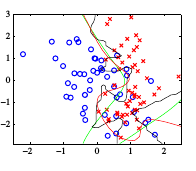

Fig.22 Illustration of the evidence framework applied to a synthetic two-class data set. The green curve shows the optimal decision boundary, the black curve shows the result of ﬁtting a two-layer network with 8 hidden units by maximum likeli- hood, and the red curve shows the result of including a regularizer in which α is optimized using the evidence pro- cedure, starting from the initial value α = 0. Note that the evidence proce- dure greatly reduces the over-ﬁtting of the network.


Using the Laplace approximation, the posterior $q(w|\mathcal{D})$ is approximated by a Gaussian:

$$
q(w|\mathcal{D}) \approx \mathcal{N}(w_{\text{MAP}}, A^{-1})
$$

where:
- $A = \nabla^2 E(w_{\text{MAP}})$ is the Hessian matrix of second derivatives,
- $w_{\text{MAP}}$ is the maximum a posteriori estimate of the weights.

### Predictive Distribution
The predictive probability is given by:
$$
p(t=1|x, \mathcal{D}) = \int \sigma(a) \, p(a|x, \mathcal{D}) \, da
$$
Approximating $p(a|x, \mathcal{D})$ as Gaussian with:
$$
\text{Mean: } a_{\text{MAP}}(x), \quad \text{Variance: } \sigma_a^2(x) = b^\top A^{-1} b
$$
the predictive probability becomes:
$$
p(t=1|x, \mathcal{D}) \approx \sigma\left(\kappa(\sigma_a^2) \, b^\top w_{\text{MAP}}\right)
$$
where:
- $b = \nabla a(x, w_{\text{MAP}})$,
- $\kappa(\sigma_a^2)$ is defined in Section 4.5.

---

## Visual Illustration

### Synthetic Two-Class Data Set
- **Green Curve**: Optimal decision boundary.
- **Black Curve**: Maximum likelihood fit using 8 hidden units in a two-layer network.
- **Red Curve**: Regularized fit with $\alpha$ optimized using the evidence procedure, reducing overfitting.

$$
\text{Figure 5.22: Evidence framework applied to synthetic two-class data.}
$$

### Decision Contours
- **Left Plot**: Decision contours from using $\sigma(a)$ approximation ($w_{\text{MAP}}$).
- **Right Plot**: Improved results accounting for $\sigma_a^2$, showing spread contours and less confident predictions.

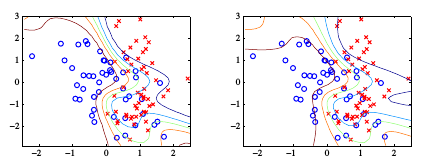

Fig.23 An illustration of the Laplace approximation for a Bayesian neural network having 8 hidden units with ‘tanh’ activation functions and a single logistic-sigmoid output unit. The weight parameters were found using scaled conjugate gradients, and the hyperparameter α was optimized using the evidence framework. On the left is the result of using the simple approximation (5.185) based on a point estimate wMAP of the parameters, in which the green curve shows the y = 0.5 decision boundary, and the other contours correspond to output probabilities of y = 0.1, 0.3, 0.7, and 0.9. On the right is the corresponding result obtained using (5.190). Note that the effect of marginalization is to spread out the contours and to make the predictions less conﬁdent, so that at each input point x, the posterior probabilities are shifted towards 0.5, while the y = 0.5 contour itself is unaffected.

---

## Key Takeaways
1. **Overfitting Reduction**: Regularization via $\alpha$ optimization significantly mitigates overfitting.
2. **Marginalization Effects**: Including posterior variance spreads probability contours and shifts predictions towards $0.5$.
3. **Applicability**: The framework is extensible to multiclass classification using softmax outputs.


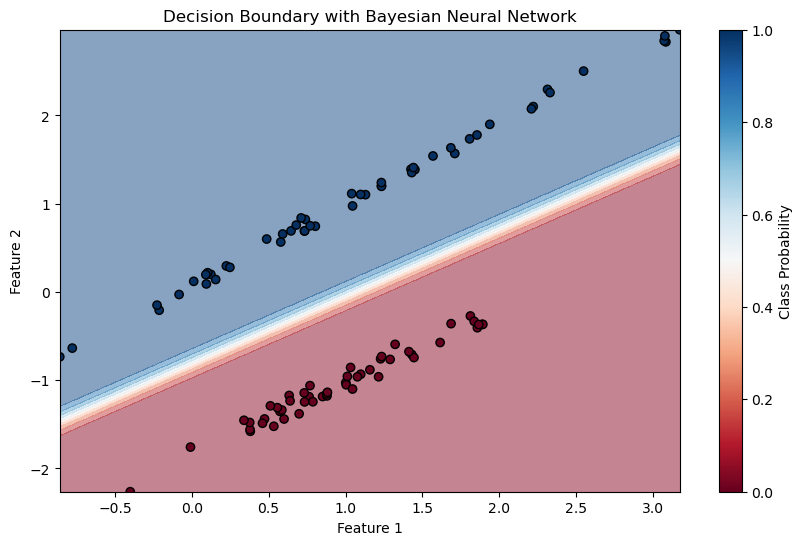

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.datasets import make_classification

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Neural network forward pass (2-layer, single logistic output)
def forward_pass(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = np.tanh(Z1)  # Hidden layer activation (tanh)
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)  # Output layer (sigmoid)
    return A2, A1

# Regularized error function (negative log-likelihood + regularization)
def error_function(params, X, t, alpha, W1_shape, W2_shape):
    # Unpack parameters
    W1 = params[:np.prod(W1_shape)].reshape(W1_shape)
    W2 = params[np.prod(W1_shape):np.prod(W1_shape) + np.prod(W2_shape)].reshape(W2_shape)
    b1 = params[np.prod(W1_shape) + np.prod(W2_shape):np.prod(W1_shape) + np.prod(W2_shape) + W1_shape[1]]
    b2 = params[np.prod(W1_shape) + np.prod(W2_shape) + W1_shape[1]:]

    # Forward pass
    y_pred, _ = forward_pass(X, W1, b1, W2, b2)
    
    # Negative log-likelihood
    log_likelihood = -np.sum(t * np.log(y_pred + 1e-10) + (1 - t) * np.log(1 - y_pred + 1e-10))
    
    # Regularization term
    regularization = alpha * (np.sum(W1**2) + np.sum(W2**2))
    
    # Total error
    return log_likelihood + regularization

# Hessian matrix approximation using finite differences
def compute_hessian(X, t, params, alpha, W1_shape, W2_shape):
    epsilon = 1e-5
    hessian = np.zeros((len(params), len(params)))
    for i in range(len(params)):
        params_plus = np.copy(params)
        params_minus = np.copy(params)
        params_plus[i] += epsilon
        params_minus[i] -= epsilon
        error_plus = error_function(params_plus, X, t, alpha, W1_shape, W2_shape)
        error_minus = error_function(params_minus, X, t, alpha, W1_shape, W2_shape)
        hessian[i, i] = (error_plus - 2 * error_function(params, X, t, alpha, W1_shape, W2_shape) + error_minus) / (epsilon ** 2)
    return hessian

# Function to compute the Laplace approximation for posterior distribution
def laplace_approximation(X, t, W1_shape, W2_shape, alpha, initial_params):
    # Minimize the error function to find the MAP estimate of parameters
    result = minimize(error_function, initial_params, args=(X, t, alpha, W1_shape, W2_shape), method='L-BFGS-B')
    map_params = result.x
    
    # Compute the Hessian at the MAP point
    hessian = compute_hessian(X, t, map_params, alpha, W1_shape, W2_shape)
    
    # Approximate the posterior covariance
    posterior_covariance = np.linalg.inv(hessian)
    
    return map_params, posterior_covariance

# Generate synthetic data for binary classification
X, t = make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=1, n_redundant=0, random_state=42)
t = t[:, np.newaxis]  # Ensure t is a column vector

# Define the neural network architecture
input_dim = X.shape[1]
hidden_units = 8
output_dim = 1
alpha = 1e-3  # Regularization parameter

# Initialize weights and biases
W1 = np.random.randn(input_dim, hidden_units) * 0.1
W2 = np.random.randn(hidden_units, output_dim) * 0.1
b1 = np.zeros(hidden_units)
b2 = np.zeros(output_dim)

# Pack the parameters into a single vector
initial_params = np.concatenate([W1.flatten(), W2.flatten(), b1, b2])

# Apply Laplace approximation
W1_shape = (input_dim, hidden_units)
W2_shape = (hidden_units, output_dim)
map_params, posterior_covariance = laplace_approximation(X, t, W1_shape, W2_shape, alpha, initial_params)

# Extract MAP weights and biases
W1_map = map_params[:np.prod(W1_shape)].reshape(W1_shape)
W2_map = map_params[np.prod(W1_shape):np.prod(W1_shape) + np.prod(W2_shape)].reshape(W2_shape)
b1_map = map_params[np.prod(W1_shape) + np.prod(W2_shape):np.prod(W1_shape) + np.prod(W2_shape) + W1_shape[1]]
b2_map = map_params[np.prod(W1_shape) + np.prod(W2_shape) + W1_shape[1]:]

# Predict the class probabilities for the data points
y_pred, _ = forward_pass(X, W1_map, b1_map, W2_map, b2_map)

# Plot decision boundary and predictions
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
                     np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
Z, _ = forward_pass(np.c_[xx.ravel(), yy.ravel()], W1_map, b1_map, W2_map, b2_map)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, levels=np.linspace(0, 1, 11), cmap='RdBu', alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=t.flatten(), cmap='RdBu', edgecolors='k', marker='o')
plt.title('Decision Boundary with Bayesian Neural Network')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Class Probability')
plt.show()


In [5]:
import random
import math
import matplotlib.pyplot as plt

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Tanh activation function
def tanh(x):
    return math.tanh(x)

# Derivative of sigmoid function
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Derivative of tanh function
def tanh_derivative(x):
    return 1 - tanh(x) ** 2

# Function for forward pass through 2-layer neural network (tanh hidden, sigmoid output)
def forward_pass(X, W1, b1, W2, b2):
    Z1 = []
    A1 = []
    for x in X:
        Z = [sum(x[i] * W1[i][j] for i in range(len(x))) + b1[j] for j in range(len(W1[0]))]
        A = [tanh(z) for z in Z]
        Z1.append(Z)
        A1.append(A)

    Z2 = []
    A2 = []
    for a in A1:
        Z = sum(a[i] * W2[i][0] for i in range(len(a))) + b2[0]
        Z2.append(Z)
        A2.append(sigmoid(Z))

    return A2, A1, Z1

# Error function (Negative log-likelihood + regularization)
def error_function(X, t, W1, b1, W2, b2, alpha):
    A2, A1, Z1 = forward_pass(X, W1, b1, W2, b2)
    error = 0
    for i in range(len(X)):
        error += - (t[i] * math.log(A2[i] + 1e-10) + (1 - t[i]) * math.log(1 - A2[i] + 1e-10))  # Cross entropy
    regularization = alpha * (sum(sum(w**2 for w in row) for row in W1) + sum(w**2 for w in W2))
    return error + regularization

# Gradient of error function with respect to weights (backpropagation)
def backprop(X, t, W1, b1, W2, b2, alpha):
    # Forward pass
    A2, A1, Z1 = forward_pass(X, W1, b1, W2, b2)

    # Calculate error (cross-entropy loss derivative)
    dA2 = []
    for i in range(len(A2)):
        dA2.append(A2[i] - t[i])  # Derivative of sigmoid w.r.t loss

    # Backpropagate through the second layer
    dW2 = []
    db2 = []
    for i in range(len(W2)):
        dw2 = 0
        for j in range(len(X)):
            dw2 += A1[j][i] * dA2[j]
        dW2.append(dw2)
        db2.append(sum(dA2))
    
    # Backpropagate through the first layer
    dA1 = []
    for i in range(len(dA2)):
        dA1.append([W2[j][i] * dA2[i] for j in range(len(W2))])  # Derivative w.r.t A1

    dW1 = [[0] * len(W1[0]) for _ in range(len(W1))]
    db1 = [0] * len(b1)
    for i in range(len(X)):
        for j in range(len(W1)):
            for k in range(len(W1[0])):
                dW1[j][k] += X[i][j] * dA1[i][k] * tanh_derivative(Z1[i][k])  # Derivative w.r.t W1
        for j in range(len(b1)):
            db1[j] += sum(dA1[i][j] * tanh_derivative(Z1[i][j]) for i in range(len(X)))

    # Regularization gradients
    dW1 = [[dw + 2 * alpha * W1[j][k] for k, dw in enumerate(row)] for j, row in enumerate(dW1)]
    dW2 = [dw + 2 * alpha * W2[j] for j, dw in enumerate(dW2)]

    return dW1, db1, dW2, db2

# Gradient descent to optimize weights
def gradient_descent(X, t, W1, b1, W2, b2, alpha, learning_rate, epochs):
    for epoch in range(epochs):
        dW1, db1, dW2, db2 = backprop(X, t, W1, b1, W2, b2, alpha)

        # Update weights and biases
        for i in range(len(W1)):
            for j in range(len(W1[i])):
                W1[i][j] -= learning_rate * dW1[i][j]
        for i in range(len(b1)):
            b1[i] -= learning_rate * db1[i]
        for i in range(len(W2)):
            W2[i][0] -= learning_rate * dW2[i]
        b2[0] -= learning_rate * db2[0]

        # Print progress
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Error: {error_function(X, t, W1, b1, W2, b2, alpha)}')

    return W1, b1, W2, b2

# Generate synthetic data (2D for classification)
def generate_data():
    X = []
    t = []
    for _ in range(100):
        x1 = random.uniform(-2, 2)
        x2 = random.uniform(-2, 2)
        X.append([x1, x2])
        t.append(1 if x1 * x1 + x2 * x2 < 2 else 0)
    return X, t

# Visualization (Decision boundary)
def plot_decision_boundary(X, t, W1, b1, W2, b2):
    resolution = 0.1
    grid_x = []
    grid_y = []
    for i in range(-10, 10):
        for j in range(-10, 10):
            grid_x.append(i * resolution)
            grid_y.append(j * resolution)

    grid_x = [grid_x[i:i+20] for i in range(0, len(grid_x), 20)]
    grid_y = [grid_y[i:i+20] for i in range(0, len(grid_y), 20)]
    
    Z, _, _ = forward_pass(grid_x, W1, b1, W2, b2)
    Z = [1 if z >= 0.5 else 0 for z in Z]

    # Plotting the result
    plt.contourf(grid_x, grid_y, Z, cmap='coolwarm', alpha=0.8)
    plt.scatter([X[i][0] for i in range(len(X))], [X[i][1] for i in range(len(X))], c=t, cmap='coolwarm', edgecolors='k')
    plt.show()

# Main script
if __name__ == '__main__':
    # Initialize hyperparameters
    alpha = 0.1
    learning_rate = 0.01
    epochs = 1000

    # Generate synthetic data
    X, t = generate_data()

    # Initialize weights and biases
    input_dim = len(X[0])
    hidden_units = 8
    output_dim = 1
    W1 = [[random.uniform(-0.1, 0.1) for _ in range(hidden_units)] for _ in range(input_dim)]
    W2 = [[random.uniform(-0.1, 0.1)] for _ in range(hidden_units)]
    b1 = [random.uniform(-0.1, 0.1) for _ in range(hidden_units)]
    b2 = [random.uniform(-0.1, 0.1)]

    # Train the network
    W1, b1, W2, b2 = gradient_descent(X, t, W1, b1, W2, b2, alpha, learning_rate, epochs)

    # Plot decision boundary
    plot_decision_boundary(X, t, W1, b1, W2, b2)


IndexError: list index out of range

In [6]:
import random
import math
import matplotlib.pyplot as plt

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Tanh activation function
def tanh(x):
    return math.tanh(x)

# Derivative of sigmoid function
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Derivative of tanh function
def tanh_derivative(x):
    return 1 - tanh(x) ** 2

# Function for forward pass through 2-layer neural network (tanh hidden, sigmoid output)
def forward_pass(X, W1, b1, W2, b2):
    Z1 = []
    A1 = []
    for x in X:
        Z = [sum(x[i] * W1[i][j] for i in range(len(x))) + b1[j] for j in range(len(W1[0]))]
        A = [tanh(z) for z in Z]
        Z1.append(Z)
        A1.append(A)

    Z2 = []
    A2 = []
    for a in A1:
        Z = sum(a[i] * W2[i][0] for i in range(len(a))) + b2[0]
        Z2.append(Z)
        A2.append(sigmoid(Z))

    return A2, A1, Z1

# Error function (Negative log-likelihood + regularization)
def error_function(X, t, W1, b1, W2, b2, alpha):
    A2, A1, Z1 = forward_pass(X, W1, b1, W2, b2)
    error = 0
    for i in range(len(X)):
        error += - (t[i] * math.log(A2[i] + 1e-10) + (1 - t[i]) * math.log(1 - A2[i] + 1e-10))  # Cross entropy
    regularization = alpha * (sum(sum(w**2 for w in row) for row in W1) + sum(w**2 for w in W2))
    return error + regularization

# Gradient of error function with respect to weights (backpropagation)
def backprop(X, t, W1, b1, W2, b2, alpha):
    # Forward pass
    A2, A1, Z1 = forward_pass(X, W1, b1, W2, b2)

    # Calculate error (cross-entropy loss derivative)
    dA2 = []
    for i in range(len(A2)):
        dA2.append(A2[i] - t[i])  # Derivative of sigmoid w.r.t loss

    # Backpropagate through the second layer
    dW2 = [0] * len(W2)
    db2 = [0] * len(b2)
    for i in range(len(W2)):
        dw2 = 0
        for j in range(len(A1)):
            dw2 += A1[j][i] * dA2[j]
        dW2[i] = dw2
        db2[i] = sum(dA2)

    # Backpropagate through the first layer
    dA1 = []
    for i in range(len(dA2)):
        dA1.append([W2[j][i] * dA2[i] for j in range(len(W2))])  # Derivative w.r.t A1

    dW1 = [[0] * len(W1[0]) for _ in range(len(W1))]
    db1 = [0] * len(b1)
    for i in range(len(X)):
        for j in range(len(W1)):
            for k in range(len(W1[0])):
                dW1[j][k] += X[i][j] * dA1[i][k] * tanh_derivative(Z1[i][k])  # Derivative w.r.t W1
        for j in range(len(b1)):
            db1[j] += sum(dA1[i][j] * tanh_derivative(Z1[i][j]) for i in range(len(X)))

    # Regularization gradients
    dW1 = [[dw + 2 * alpha * W1[j][k] for k, dw in enumerate(row)] for j, row in enumerate(dW1)]
    dW2 = [dw + 2 * alpha * W2[j] for j, dw in enumerate(dW2)]

    return dW1, db1, dW2, db2

# Gradient descent to optimize weights
def gradient_descent(X, t, W1, b1, W2, b2, alpha, learning_rate, epochs):
    for epoch in range(epochs):
        dW1, db1, dW2, db2 = backprop(X, t, W1, b1, W2, b2, alpha)

        # Update weights and biases
        for i in range(len(W1)):
            for j in range(len(W1[i])):
                W1[i][j] -= learning_rate * dW1[i][j]
        for i in range(len(b1)):
            b1[i] -= learning_rate * db1[i]
        for i in range(len(W2)):
            W2[i][0] -= learning_rate * dW2[i]
        b2[0] -= learning_rate * db2[0]

        # Print progress
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Error: {error_function(X, t, W1, b1, W2, b2, alpha)}')

    return W1, b1, W2, b2

# Generate synthetic data (2D for classification)
def generate_data():
    X = []
    t = []
    for _ in range(100):
        x1 = random.uniform(-2, 2)
        x2 = random.uniform(-2, 2)
        X.append([x1, x2])
        t.append(1 if x1 * x1 + x2 * x2 < 2 else 0)
    return X, t

# Visualization (Decision boundary)
def plot_decision_boundary(X, t, W1, b1, W2, b2):
    resolution = 0.1
    grid_x = []
    grid_y = []
    for i in range(-10, 10):
        for j in range(-10, 10):
            grid_x.append(i * resolution)
            grid_y.append(j * resolution)

    grid_x = [grid_x[i:i+20] for i in range(0, len(grid_x), 20)]
    grid_y = [grid_y[i:i+20] for i in range(0, len(grid_y), 20)]
    
    Z, _, _ = forward_pass(grid_x, W1, b1, W2, b2)
    Z = [1 if z >= 0.5 else 0 for z in Z]

    # Plotting the result
    plt.contourf(grid_x, grid_y, Z, cmap='coolwarm', alpha=0.8)
    plt.scatter([X[i][0] for i in range(len(X))], [X[i][1] for i in range(len(X))], c=t, cmap='coolwarm', edgecolors='k')
    plt.show()

# Main script
if __name__ == '__main__':
    # Initialize hyperparameters
    alpha = 0.1
    learning_rate = 0.01
    epochs = 1000

    # Generate synthetic data
    X, t = generate_data()

    # Initialize weights and biases
    input_dim = len(X[0])
    hidden_units = 8
    output_dim = 1
    W1 = [[random.uniform(-0.1, 0.1) for _ in range(hidden_units)] for _ in range(input_dim)]
    W2 = [[random.uniform(-0.1, 0.1)] for _ in range(hidden_units)]
    b1 = [random.uniform(-0.1, 0.1) for _ in range(hidden_units)]
    b2 = [random.uniform(-0.1, 0.1)]

    # Train the network
    W1, b1, W2, b2 = gradient_descent(X, t, W1, b1, W2, b2, alpha, learning_rate, epochs)

    # Plot decision boundary
    plot_decision_boundary(X, t, W1, b1, W2, b2)


IndexError: list assignment index out of range

In [ ]:
import random
import math
import matplotlib.pyplot as plt

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Tanh activation function
def tanh(x):
    return math.tanh(x)

# Derivative of sigmoid function
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Derivative of tanh function
def tanh_derivative(x):
    return 1 - tanh(x) ** 2

# Function for forward pass through 2-layer neural network (tanh hidden, sigmoid output)
def forward_pass(X, W1, b1, W2, b2):
    Z1 = []
    A1 = []
    for x in X:
        Z = [sum(x[i] * W1[i][j] for i in range(len(x))) + b1[j] for j in range(len(W1[0]))]
        A = [tanh(z) for z in Z]
        Z1.append(Z)
        A1.append(A)

    Z2 = []
    A2 = []
    for a in A1:
        Z = sum(a[i] * W2[i][0] for i in range(len(a))) + b2
        Z2.append(Z)
        A2.append(sigmoid(Z))

    return A2, A1, Z1

# Error function (Negative log-likelihood + regularization)
def error_function(X, t, W1, b1, W2, b2, alpha):
    A2, A1, Z1 = forward_pass(X, W1, b1, W2, b2)
    error = 0
    for i in range(len(X)):
        error += - (t[i] * math.log(A2[i] + 1e-10) + (1 - t[i]) * math.log(1 - A2[i] + 1e-10))  # Cross entropy
    regularization = alpha * (sum(sum(w**2 for w in row) for row in W1) + sum(w**2 for w in W2))
    return error + regularization

# Gradient of error function with respect to weights (backpropagation)
def backprop(X, t, W1, b1, W2, b2, alpha):
    # Forward pass
    A2, A1, Z1 = forward_pass(X, W1, b1, W2, b2)

    # Calculate error (cross-entropy loss derivative)
    dA2 = []
    for i in range(len(A2)):
        dA2.append(A2[i] - t[i])  # Derivative of sigmoid w.r.t loss

    # Backpropagate through the second layer
    dW2 = [0] * len(W2)
    db2 = 0  # Only one bias for the output layer
    for i in range(len(W2)):
        dw2 = 0
        for j in range(len(A1)):
            dw2 += A1[j][i] * dA2[j]
        dW2[i] = dw2
    db2 = sum(dA2)  # Sum of errors for the output bias

    # Backpropagate through the first layer
    dA1 = []
    for i in range(len(dA2)):
        dA1.append([W2[j][0] * dA2[i] for j in range(len(W2))])  # Derivative w.r.t A1

    dW1 = [[0] * len(W1[0]) for _ in range(len(W1))]
    db1 = [0] * len(b1)
    for i in range(len(X)):
        for j in range(len(W1)):
            for k in range(len(W1[0])):
                dW1[j][k] += X[i][j] * dA1[i][k] * tanh_derivative(Z1[i][k])  # Derivative w.r.t W1
        for j in range(len(b1)):
            db1[j] += sum(dA1[i][j] * tanh_derivative(Z1[i][j]) for i in range(len(X)))

    # Regularization gradients
    dW1 = [[dw + 2 * alpha * W1[j][k] for k, dw in enumerate(row)] for j, row in enumerate(dW1)]
    dW2 = [dw + 2 * alpha * W2[j][0] for j, dw in enumerate(dW2)]

    return dW1, db1, dW2, db2

# Gradient descent to optimize weights
def gradient_descent(X, t, W1, b1, W2, b2, alpha, learning_rate, epochs):
    for epoch in range(epochs):
        dW1, db1, dW2, db2 = backprop(X, t, W1, b1, W2, b2, alpha)

        # Update weights and biases
        for i in range(len(W1)):
            for j in range(len(W1[0])):
                W1[i][j] -= learning_rate * dW1[i][j]
        for i in range(len(W2)):
            W2[i][0] -= learning_rate * dW2[i]
        b1 = [b1_i - learning_rate * db1_i for b1_i, db1_i in zip(b1, db1)]
        b2 -= learning_rate * db2

    return W1, b1, W2, b2
# Main script
if __name__ == '__main__':
    # Initialize hyperparameters
    alpha = 0.1
    learning_rate = 0.01
    epochs = 1000

    # Generate synthetic data
    X, t = generate_data()

    # Initialize weights and biases
    input_dim = len(X[0])
    hidden_units = 8
    output_dim = 1
    W1 = [[random.uniform(-0.1, 0.1) for _ in range(hidden_units)] for _ in range(input_dim)]
    W2 = [[random.uniform(-0.1, 0.1)] for _ in range(hidden_units)]
    b1 = [random.uniform(-0.1, 0.1) for _ in range(hidden_units)]
    b2 = random.uniform(-0.1, 0.1)

    # Train the network
    W1, b1, W2, b2 = gradient_descent(X, t, W1, b1, W2, b2, alpha, learning_rate, epochs)

    # Plot decision boundary
    plot_decision_boundary(X, t, W1, b1, W2, b2)
